# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [61]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from prettytable import PrettyTable
from matplotlib import mlab

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [00:28<00:00, 3093.88it/s]


In [23]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

# [4] Splitting the data

In [23]:
X = preprocessed_reviews
Y = final['Score'].values

In [24]:
#from sklearn.model_selection import train_test_split

# Here we are splitting the data(X ,Y) into train, cross-validation and test data
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=Flase)# this is for time series split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30) # this is random splitting
X_train, X_cv, Y_train, Y_cv     = train_test_split(X_train, Y_train, test_size=0.30) # this is random splitting


# [4] Featurization

## [4.1] BAG OF WORDS

In [25]:
#BoW
vectorizerb = CountVectorizer(min_df = 10)
vectorizerb.fit(X_train) # fit has to happen only on train data
print(vectorizerb.get_feature_names()[:20])# printing some feature names
print("="*50)

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizerb.transform(X_train)
X_cv_bow = vectorizerb.transform(X_cv)
X_test_bow = vectorizerb.transform(X_test)


print("After vectorizations")
print(X_train_bow.shape, Y_train.shape)
print(X_cv_bow.shape, Y_cv.shape)
print(X_test_bow.shape, Y_test.shape)
print("="*100)

print("the type of count vectorizer ")
print(type(X_train_bow))
print(type(X_cv_bow))
print(type(X_test_bow))

['aa', 'aafco', 'ability', 'able', 'absence', 'absent', 'absolute', 'absolutely', 'absolutly', 'absorb', 'absorbed', 'absorbs', 'absorption', 'abundant', 'academy', 'acai', 'acana', 'accent', 'accept', 'acceptable']
After vectorizations
(43008, 8101) (43008,)
(18433, 8101) (18433,)
(26332, 8101) (26332,)
the type of count vectorizer 
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


## [4.3] TF-IDF

In [26]:
tfidf_vect = TfidfVectorizer(min_df=10)
tfidf_vect.fit(X_train)
print("some sample features ",tfidf_vect.get_feature_names()[0:10])
print('='*50)

# we use the fitted CountVectorizer to convert the text to vector
X_train_tfidf = tfidf_vect.transform(X_train)
X_cv_tfidf = tfidf_vect.transform(X_cv)
X_test_tfidf = tfidf_vect.transform(X_test)

print("After vectorizations")
print(X_train_tfidf.shape, Y_train.shape)
print(X_cv_tfidf.shape, Y_cv.shape)
print(X_test_tfidf.shape, Y_test.shape)
print("="*100)

print("the type of count vectorizer ")
print(type(X_train_tfidf))
print(type(X_cv_tfidf))
print(type(X_test_tfidf))

some sample features  ['aa', 'aafco', 'ability', 'able', 'absence', 'absent', 'absolute', 'absolutely', 'absolutly', 'absorb']
After vectorizations
(43008, 8101) (43008,)
(18433, 8101) (18433,)
(26332, 8101) (26332,)
the type of count vectorizer 
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


## [4.4] Word2Vec

In [83]:
# Train your own Word2Vec model using your own text corpus
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

In [84]:
# this line of code trains your w2v model on the give list of sentances, fitting the data
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=-1)

In [85]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  12469
sample words  ['beagles', 'love', 'food', 'little', 'worried', 'reading', 'reviews', 'weight', 'gain', 'dogs', 'experiencing', 'tendency', 'put', 'using', 'adult', 'lite', 'formula', 'would', 'get', 'hungry', 'feedings', 'bug', 'gave', 'whats', 'since', 'made', 'switch', 'feed', 'less', 'time', 'satisfied', 'no', 'gas', 'runny', 'stool', 'recommend', 'dog', 'lovers', 'trying', 'give', 'best', 'mix', 'whey', 'protein', 'isolate', 'un', 'hulled', 'organic', 'sesame', 'seed']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

### Converting Train data text

In [86]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

100%|███████████████████████████████████████████████████████████████████████████| 43008/43008 [01:51<00:00, 386.52it/s]


(43008, 50)
[-9.20977168e-04 -2.62901402e-04 -1.24378716e-03 -1.57319791e-04
  5.98810116e-05  1.08551165e-03 -5.28792135e-04 -8.77466923e-04
 -1.53270885e-03  8.66955069e-05 -2.46861111e-04  1.87352263e-04
  5.59329896e-04 -7.12459862e-04 -3.87754817e-04  8.75376305e-04
 -2.40781712e-04 -9.24346357e-04  6.34178550e-04 -9.28385325e-04
 -1.84821904e-05 -1.13730007e-03  8.22906492e-04  1.83632819e-03
 -7.27313156e-04 -1.01738588e-04 -6.70573247e-04 -1.83118674e-03
  1.19111032e-03 -1.50023999e-03  4.39717542e-04 -2.23893134e-03
  1.09100041e-03  5.31805423e-05 -8.47370467e-04 -3.36606106e-04
 -1.57798268e-03 -2.20810941e-04  7.00341833e-05 -1.75991464e-04
  9.68675361e-04  1.88565005e-03  8.69625657e-04  8.12293115e-05
 -5.80354220e-04  1.80386371e-04  8.15080039e-04 -1.95798032e-03
 -6.17218626e-04 -5.33464381e-04]


### Converting CV data set

In [87]:
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

In [88]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

100%|███████████████████████████████████████████████████████████████████████████| 18433/18433 [00:48<00:00, 380.27it/s]


(18433, 50)
[ 6.36758921e-04 -3.22297540e-03 -3.52984840e-03 -8.19505138e-04
 -5.37860698e-04  5.59060294e-04 -1.40478836e-03 -2.10203056e-04
  1.65505802e-04  1.95176308e-04 -1.99217785e-03 -6.27172298e-05
  6.06064506e-04  7.52241529e-04  1.34496103e-04 -7.23200499e-04
  1.08443266e-03 -1.43231591e-04  2.71784125e-03 -1.54025779e-03
 -1.16689521e-03  1.96472277e-03  1.71092739e-03  2.44592261e-04
  1.33712294e-03 -8.94514981e-05 -3.93841068e-05  7.96984482e-04
  7.66680040e-04  1.85681255e-03  2.97937979e-03 -7.53948775e-04
 -1.52100524e-03  6.65586482e-04  8.65623346e-04  1.00250211e-03
  5.97029392e-04 -1.18704038e-03  1.19535701e-03  1.35434439e-03
  5.34404951e-05 -8.11878755e-04  5.40677252e-04 -9.82659950e-04
  5.69844500e-04 -8.92694997e-04  2.87000999e-04  1.42793218e-03
 -1.45332540e-03 -1.10055001e-03]


### Converting Test data set

In [89]:
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [90]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|███████████████████████████████████████████████████████████████████████████| 26332/26332 [01:09<00:00, 378.46it/s]


(26332, 50)
[-1.59844072e-03  7.58379172e-04 -1.78729943e-04  1.23153026e-04
 -1.23894293e-04  2.01177212e-03  8.48205265e-04  2.20336647e-03
  2.67048531e-04 -1.20540381e-03  2.70881126e-03 -3.35108475e-04
  2.67536770e-03  5.54078483e-04  3.45815244e-05 -9.58713987e-04
 -2.51264600e-04  2.01500967e-04 -4.45649266e-04 -8.65552607e-04
  6.89085869e-04  8.47349834e-04  1.91838075e-03  1.57579691e-03
  1.82565583e-03  1.62166423e-04  7.36111102e-04  2.71051938e-04
  4.74309934e-04  1.71959211e-03  2.41457570e-04  1.48060523e-03
 -3.15647163e-04 -9.15031543e-05  1.75016316e-03 -3.26641760e-04
  9.33087640e-04  9.84536942e-04 -5.69839848e-04  7.45966225e-04
  6.92062489e-04  2.53437213e-04 -1.72437280e-03 -5.73539320e-04
 -1.41352436e-04 -1.04494459e-03 -5.86548941e-04 -1.26160682e-03
  2.51154052e-03 -1.11418288e-03]


#### [4.4.1.2] TFIDF weighted W2v

### Converting train data set 

In [91]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix_train = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [92]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 43008/43008 [19:37<00:00, 32.03it/s]


### Converting CV data set

In [93]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 18433/18433 [05:06<00:00, 60.07it/s]


### Converting Test data set

In [94]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 26332/26332 [05:42<00:00, 76.98it/s]


# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X i.e Train data.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

## Hyperparameter tuning using GridSearch

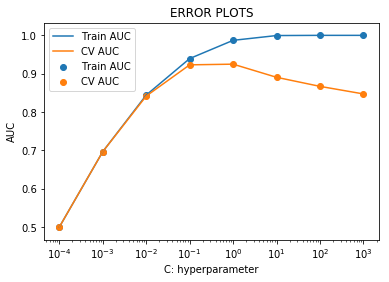

In [27]:
#clf = LogisticRegression()
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
parameters = {'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid = GridSearchCV(LogisticRegression(penalty = 'l1'), parameters, cv=3, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train_bow, Y_train)

#a = grid.best_params_
best_c = grid.best_params_.get('C')

train_auc_bow = grid.cv_results_['mean_train_score']
cv_auc_bow = grid.cv_results_['mean_test_score'] 

plt.plot(C, train_auc_bow, label='Train AUC')
plt.scatter(C, train_auc_bow, label='Train AUC')
plt.plot(C, cv_auc_bow, label='CV AUC')
plt.scatter(C, cv_auc_bow, label='CV AUC')

plt.legend()
plt.xscale('log')
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [28]:
print(best_c)

1


In [29]:
print(grid.best_estimator_)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


## Testing with Testing data 

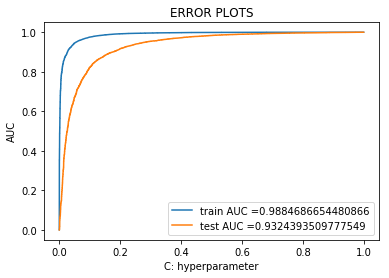

In [30]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve

clf = LogisticRegression()
clf.fit(X_train_bow, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr_bow, train_tpr_bow, thresholds_bow = roc_curve(Y_train, clf.predict_proba(X_train_bow)[:,1])
test_fpr_bow, test_tpr_bow, thresholds_bow = roc_curve(Y_test, clf.predict_proba(X_test_bow)[:,1])

plt.plot(train_fpr_bow, train_tpr_bow, label="train AUC ="+str(auc(train_fpr_bow, train_tpr_bow)))
plt.plot(test_fpr_bow, test_tpr_bow, label="test AUC ="+str(auc(test_fpr_bow, test_tpr_bow)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

### Calculating Accuracy, Precision, Recall & F1

In [76]:
#L1 Regularizer
clf = LogisticRegression(C = 1, penalty='l1')

clf.fit(X_train_bow,Y_train)

predl1 = clf.predict(X_test_bow)

accb1 = accuracy_score(Y_test, predl1) * 100
preb1 = precision_score(Y_test, predl1) * 100
recb1 = recall_score(Y_test, predl1) * 100
f1b1 = f1_score(Y_test, predl1) * 100


print("Accuracy : " + str(accb1))
print("Precision : " + str(preb1))
print("Recall : "+ str(recb1))
print("F1 : " + str(f1b1))

Accuracy : 91.4818471821358
Precision : 93.85062021641593
Recall : 96.1904332536856
F1 : 95.00612267616609


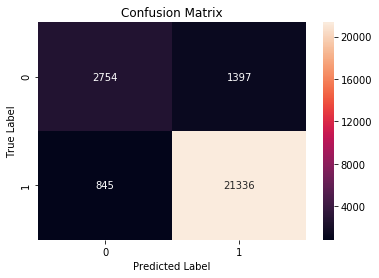

In [32]:
cm = confusion_matrix(Y_test,predl1)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [33]:
# Please write all the code with proper documentation
clf = LogisticRegression(C=100, penalty='l1')
clf.fit(X_train_bow, Y_train)

s1 = np.count_nonzero(clf.coef_)
print(np.count_nonzero(clf.coef_))
print(clf.coef_)

7063
[[ 0.          0.          0.         ...  7.58361217 -1.80794967
   0.        ]]


In [34]:
clf = LogisticRegression(C=0.1, penalty='l1')
clf.fit(X_train_bow, Y_train)

s2 = np.count_nonzero(clf.coef_)
print(np.count_nonzero(clf.coef_))
print(clf.coef_)

728
[[0. 0. 0. ... 0. 0. 0.]]


In [35]:
clf = LogisticRegression(C=0.01, penalty='l1')
clf.fit(X_train_bow, Y_train)

s3 = np.count_nonzero(clf.coef_)
print(np.count_nonzero(clf.coef_))
print(clf.coef_)

91
[[0. 0. 0. ... 0. 0. 0.]]


In [36]:
clf = LogisticRegression(C=0.001, penalty='l1')
clf.fit(X_train_bow, Y_train)

s4 = np.count_nonzero(clf.coef_)
print(np.count_nonzero(clf.coef_))
print(clf.coef_)

3
[[0. 0. 0. ... 0. 0. 0.]]


In [100]:
name= ["GRID", "GRID"]
c= [100,0.1,0.01,0.001]
s=[s1,s2,s3,s4]


#Initialize Prettytable
ptable = PrettyTable()
ptable.add_column("C", c)
ptable.add_column("Sparsity", s)


print(ptable)

+-------+----------+
|   C   | Sparsity |
+-------+----------+
|  100  |   7063   |
|  0.1  |   728    |
|  0.01 |    91    |
| 0.001 |    3     |
+-------+----------+


### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

### Calculating Accuracy, Precision, Recall & F1

In [77]:
# L2 Regularizer
clf = LogisticRegression(C = 1, penalty='l2')

clf.fit(X_train_bow,Y_train)

predl2 = clf.predict(X_test_bow)

accb2 = accuracy_score(Y_test, predl2) * 100
preb2 = precision_score(Y_test, predl2) * 100
recb2 = recall_score(Y_test, predl2) * 100
f1b2 = f1_score(Y_test, predl2) * 100


print("Accuracy : " + str(accb2))
print("Precision : " + str(preb2))
print("Recall : "+ str(recb2))
print("F1 : " + str(f1b2))

Accuracy : 91.44387057572536
Precision : 93.92910678070717
Recall : 96.0506740002705
F1 : 94.97804426810511


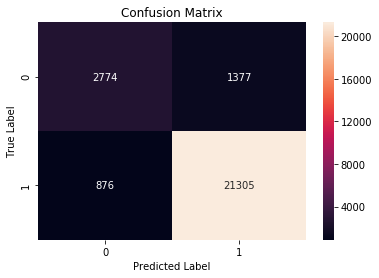

In [39]:
cm = confusion_matrix(Y_test,predl2)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [78]:
# Please compare all your models using Prettytable library
name= ["GRID", "GRID"]
reg= ["L1","L2"]
acc= [accb1,accb2]
pre= [preb1,preb2]
rec= [recb1,recb2]
f1= [f1b1,f1b2]


#Initialize Prettytable
ptable = PrettyTable()
ptable.add_column("Hyperparameter", name)
ptable.add_column("Regularizer", reg)
ptable.add_column("Accuracy%", acc)
ptable.add_column("Precision%", pre)
ptable.add_column("Recall%", rec)
ptable.add_column("F1%", f1)

print(ptable)

+----------------+-------------+-------------------+-------------------+------------------+-------------------+
| Hyperparameter | Regularizer |     Accuracy%     |     Precision%    |     Recall%      |        F1%        |
+----------------+-------------+-------------------+-------------------+------------------+-------------------+
|      GRID      |      L1     |  91.4818471821358 | 93.85062021641593 | 96.1904332536856 | 95.00612267616609 |
|      GRID      |      L2     | 91.44387057572536 | 93.92910678070717 | 96.0506740002705 | 94.97804426810511 |
+----------------+-------------+-------------------+-------------------+------------------+-------------------+


#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [41]:
#Weights before adding noise
old_weg = clf.coef_[0]
print(old_weg)

X_train_noise = X_train_bow.todense()

#Adding noise
X_train_noise_t = X_train_noise.astype('float64')
X_train_noise_t += 0.01
print(X_train_noise_t)

#Training model with noisy data
clf = LogisticRegression(C = 1 , penalty='l2')
clf.fit(X_train_noise_t,Y_train)

#Weights after adding noise
new_weg = clf.coef_[0]
print(new_weg)
print(new_weg.size)

[-0.12452753  0.01725924  0.52043825 ...  0.18088959  0.28956795
  0.10230405]
[[0.01 0.01 0.01 ... 0.01 0.01 0.01]
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]
 ...
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]]
[-0.12769705  0.01579193  0.521005   ...  0.17928473  0.2892642
  0.10011302]
8101


In [54]:
difference = (abs((old_weg-new_weg)/old_weg))*100
print(difference)

[2.54523744 8.50157227 0.10889994 ... 0.88720407 0.10489762 2.14168657]


In [53]:
print(np.percentile(difference,90))
print(np.percentile(difference,91))
print(np.percentile(difference,94))
print(np.percentile(difference,97))
print(np.percentile(difference,98))
print(np.percentile(difference,99))
print(np.percentile(difference,99.1))
print(np.percentile(difference,99.2))
print(np.percentile(difference,99.4))
print(np.percentile(difference,99.6))
print(np.percentile(difference,99.7))
print(np.percentile(difference,99.8))
print(np.percentile(difference,99.9))
print(np.percentile(difference,100))


1.5665473336487306
1.73154770944275
2.603184161110672
4.817723279901305
7.992467002853713
14.665209613473754
16.674836319685518
17.759561807037173
26.070037505553437
45.25995779992553
60.87161889762165
100.6723207907454
254.11791579732613
9242.726249068579


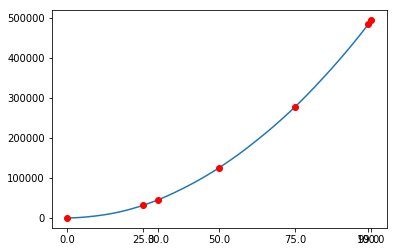

In [66]:
#https://stackoverflow.com/questions/18153054/percentiles-on-x-axis-with-matplotlib
d = np.sort(np.random.randint(0,1000,1000)).cumsum()

# Percentile values
p = np.array([0.0, 25.0, 30.0, 50.0, 75.0, 99.0, 100.0])

perc = mlab.prctile(d, p=p)

plt.plot(d)
# Place red dots on the percentiles
plt.plot((len(d)-1) * p/100., perc, 'ro')

# Set tick locations and labels
plt.xticks((len(d)-1) * p/100., map(str, p))

plt.show()

In [69]:
print(difference[np.where(difference > 25)].size)

51


### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [132]:
# this code is copied from here:https://stackoverflow.com/questions/26976362/how-to-get-most-informative-features-for-scikit-learn-classifier-for-different-c

def most_informative_feature_for_binary_classification(vectorizer, classifier, n=10):
    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[-n:]

    
    for coef, feat in reversed(topn_class1):
        print (class_labels[1], coef, feat)


most_informative_feature_for_binary_classification(vectorizerb, clf)

1 2.8687310535917736 pleasantly
1 2.4082679631154256 satisfied
1 2.210133552371643 hooked
1 2.146384676901295 amazing
1 2.076545491015456 excellent
1 2.051208688613232 delicious
1 1.9052016062453565 yummy
1 1.8874359671304837 amazed
1 1.86098552839777 compares
1 1.7975113044415867 beat


#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [133]:
# this code is copied from here:https://stackoverflow.com/questions/26976362/how-to-get-most-informative-features-for-scikit-learn-classifier-for-different-c

def most_informative_feature_for_binary_classification(vectorizer, classifier, n=10):
    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    
    for coef, feat in topn_class2:
        print( class_labels[0], coef, feat)


most_informative_feature_for_binary_classification(vectorizerb, clf)

0 -3.0923685890351136 worst
0 -2.4625352214614304 disappointment
0 -2.405131771995396 closely
0 -2.398231395243532 sounded
0 -2.3886624782949277 cancelled
0 -2.378952400379236 awful
0 -2.350115053095102 disappointing
0 -2.2960626229124586 hopes
0 -2.2693369354015647 terrible
0 -2.236787074732326 undrinkable


## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

### Hyperparameter tuning using GridSearch

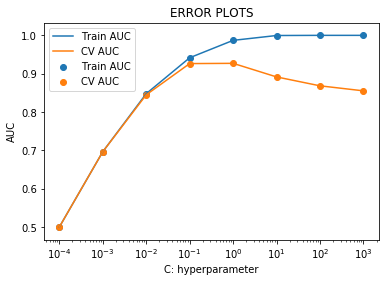

In [134]:
#clf = LogisticRegression()
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
parameters = {'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid = GridSearchCV(LogisticRegression(penalty = 'l1'), parameters, cv=3, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train_bow, Y_train)

#a = grid.best_params_
best_c = grid.best_params_.get('C')

train_auc_tfidf = grid.cv_results_['mean_train_score']
cv_auc_tfidf = grid.cv_results_['mean_test_score'] 

plt.plot(C, train_auc_tfidf, label='Train AUC')
plt.scatter(C, train_auc_tfidf, label='Train AUC')
plt.plot(C, cv_auc_tfidf, label='CV AUC')
plt.scatter(C, cv_auc_tfidf, label='CV AUC')

plt.legend()
plt.xscale('log')
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [135]:
print(best_c)

1


In [136]:
print(grid.best_estimator_)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


## Testing with Test data 

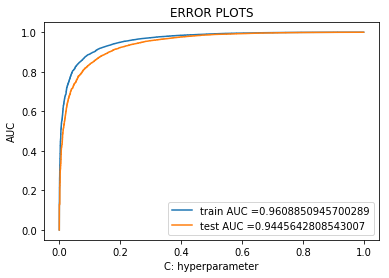

In [138]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve

clf = LogisticRegression(penalty='l1')
clf.fit(X_train_tfidf, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr_tfidf, train_tpr_tfidf, thresholds_tfidf = roc_curve(Y_train, clf.predict_proba(X_train_tfidf)[:,1])
test_fpr_tfidf, test_tpr_tfidf, thresholds_tfidf = roc_curve(Y_test, clf.predict_proba(X_test_tfidf)[:,1])

plt.plot(train_fpr_tfidf, train_tpr_tfidf, label="train AUC ="+str(auc(train_fpr_tfidf, train_tpr_tfidf)))
plt.plot(test_fpr_tfidf, test_tpr_tfidf, label="test AUC ="+str(auc(test_fpr_tfidf, test_tpr_tfidf)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

### Calculating Accuracy, Precision, Recall & F1

In [79]:
#L1 Regularizer
clf = LogisticRegression(C = 1, penalty='l1')

clf.fit(X_train_tfidf,Y_train)

predt1 = clf.predict(X_test_tfidf)

acct1 = accuracy_score(Y_test, predt1) * 100
pret1 = precision_score(Y_test, predt1) * 100
rect1 = recall_score(Y_test, predt1) * 100
f1t1 = f1_score(Y_test, predt1) * 100


print("Accuracy : " + str(acct1))
print("Precision : " + str(pret1))
print("Recall : "+ str(rect1))
print("F1 : " + str(f1t1))

Accuracy : 91.77426705149628
Precision : 93.24575428892442
Recall : 97.28145710292593
F1 : 95.2208640395393


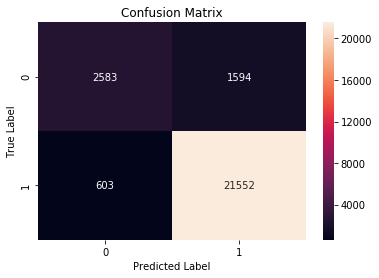

In [140]:
cm = confusion_matrix(Y_test,predt1)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

### Calculating Accuracy, Precision, Recall & F1

In [80]:
# L2 Regularizer
clf = LogisticRegression(C = 1, penalty='l2')

clf.fit(X_train_tfidf,Y_train)

predt2 = clf.predict(X_test_tfidf)

acct2 = accuracy_score(Y_test, predt2) * 100
pret2 = precision_score(Y_test, predt2) * 100
rect2 = recall_score(Y_test, predt2) * 100
f1t2 = f1_score(Y_test, predt2) * 100


print("Accuracy : " + str(acct2))
print("Precision : " + str(pret2))
print("Recall : "+ str(rect2))
print("F1 : " + str(f1t2))

Accuracy : 91.69831383867538
Precision : 92.3928253402875
Recall : 98.23272169875118
F1 : 95.22331963989161


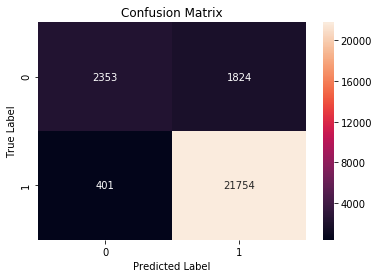

In [142]:
cm = confusion_matrix(Y_test,predt2)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [144]:
# this code is copied from here:https://stackoverflow.com/questions/26976362/how-to-get-most-informative-features-for-scikit-learn-classifier-for-different-c

def most_informative_feature_for_binary_classification(vectorizer, classifier, n=10):
    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[-n:]

    
    for coef, feat in reversed(topn_class1):
        print (class_labels[1], coef, feat)


most_informative_feature_for_binary_classification(tfidf_vect, clf)

1 9.704297214578249 great
1 7.987935765742484 best
1 7.3283042837775545 delicious
1 6.192219042721783 perfect
1 5.780201538715221 nice
1 5.763099509902627 loves
1 5.755635831789511 good
1 5.719272092890176 excellent
1 5.457260900783352 love
1 5.2232073193425235 wonderful


#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [143]:
# this code is copied from here:https://stackoverflow.com/questions/26976362/how-to-get-most-informative-features-for-scikit-learn-classifier-for-different-c

def most_informative_feature_for_binary_classification(vectorizer, classifier, n=10):
    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    
    for coef, feat in topn_class2:
        print( class_labels[0], coef, feat)


most_informative_feature_for_binary_classification(tfidf_vect, clf)


0 -6.985364410392888 not
0 -6.580207768799396 worst
0 -6.236374144075262 disappointed
0 -5.564541474219999 awful
0 -5.232906116688167 terrible
0 -5.152253527463616 horrible
0 -4.9229359910569634 disappointing
0 -4.788835329559626 disappointment
0 -4.547341320639886 unfortunately
0 -4.331842626836214 return


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

## Hyperparameter tuning with Train data 

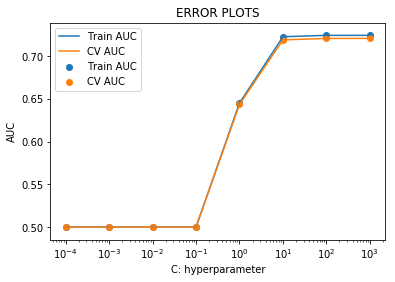

In [168]:
#clf = LogisticRegression()
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
parameters = {'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid = GridSearchCV(LogisticRegression(penalty = 'l1'), parameters, cv=3, scoring='roc_auc', n_jobs=-1)
grid.fit(sent_vectors_train, Y_train)

#a = grid.best_params_
best_c = grid.best_params_.get('C')

train_auc_aw2v = grid.cv_results_['mean_train_score']
cv_auc_aw2v = grid.cv_results_['mean_test_score'] 

plt.plot(C, train_auc_aw2v, label='Train AUC')
plt.scatter(C, train_auc_aw2v, label='Train AUC')
plt.plot(C, cv_auc_aw2v, label='CV AUC')
plt.scatter(C, cv_auc_aw2v, label='CV AUC')

plt.legend()
plt.xscale('log')
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [170]:
print(best_c)

1000


In [171]:
print(grid.best_estimator_)

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


## Testing with Test data 

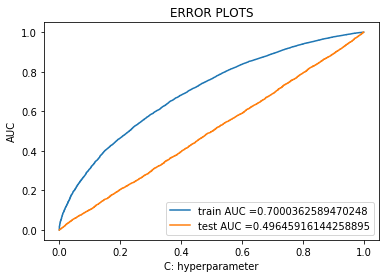

In [176]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve

clf = LogisticRegression()
clf.fit(sent_vectors_train, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr_aw2v, train_tpr_aw2v, thresholds_aw2v = roc_curve(Y_train, clf.predict_proba(sent_vectors_train)[:,1])
test_fpr_aw2v, test_tpr_aw2v, thresholds_aw2v = roc_curve(Y_test, clf.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr_aw2v, train_tpr_aw2v, label="train AUC ="+str(auc(train_fpr_aw2v, train_tpr_aw2v)))
plt.plot(test_fpr_aw2v, test_tpr_aw2v, label="test AUC ="+str(auc(test_fpr_aw2v, test_tpr_aw2v)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

### Calculating Accuracy, Precision, Recall & F1

In [95]:
#L1 Regularizer
clf = LogisticRegression(C = 1000, penalty='l1')

clf.fit(sent_vectors_train,Y_train)

predw1 = clf.predict(sent_vectors_test)

acca1 = accuracy_score(Y_test, predw1) * 100
prea1 = precision_score(Y_test, predw1) * 100
reca1 = recall_score(Y_test, predw1) * 100
f1a1 = f1_score(Y_test, predw1) * 100


print("Accuracy : " + str(acca1))
print("Precision : " + str(prea1))
print("Recall : "+ str(reca1))
print("F1 : " + str(f1a1))

Accuracy : 84.34984049825309
Precision : 84.92419554455446
Recall : 98.99463504801406
F1 : 91.42119616129234


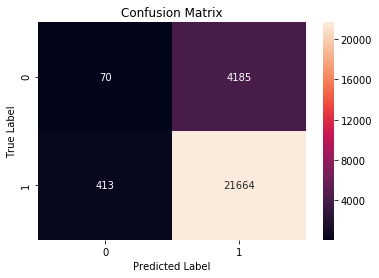

In [178]:
cm = confusion_matrix(Y_test,predw1)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

In [96]:
#L1 Regularizer
clf = LogisticRegression(C = 1000, penalty='l2')

clf.fit(sent_vectors_train,Y_train)

predw2 = clf.predict(sent_vectors_test)

acca2 = accuracy_score(Y_test, predw2) * 100
prea2 = precision_score(Y_test, predw2) * 100
reca2 = recall_score(Y_test, predw2) * 100
f1a2 = f1_score(Y_test, predw2) * 100


print("Accuracy : " + str(acca2))
print("Precision : " + str(prea2))
print("Recall : "+ str(reca2))
print("F1 : " + str(f1a2))

Accuracy : 84.37262646209935
Precision : 84.76102516739783
Recall : 99.30120373292456
F1 : 91.45680652729047


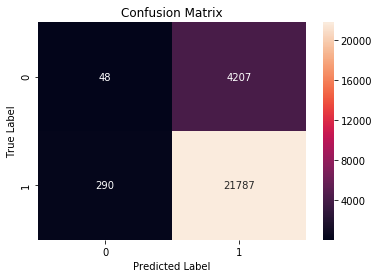

In [181]:
cm = confusion_matrix(Y_test,predw2)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

## Hyperparameter tuning with Train data 

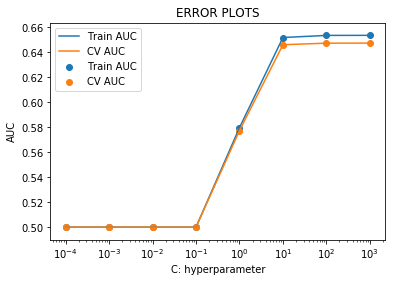

In [185]:
#clf = LogisticRegression()
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
parameters = {'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid = GridSearchCV(LogisticRegression(penalty = 'l1'), parameters, cv=3, scoring='roc_auc', n_jobs=-1)
grid.fit(tfidf_sent_vectors_train, Y_train)

#a = grid.best_params_
best_c = grid.best_params_.get('C')

train_auc_tfw2v = grid.cv_results_['mean_train_score']
cv_auc_tfw2v = grid.cv_results_['mean_test_score'] 

plt.plot(C, train_auc_tfw2v, label='Train AUC')
plt.scatter(C, train_auc_tfw2v, label='Train AUC')
plt.plot(C, cv_auc_tfw2v, label='CV AUC')
plt.scatter(C, cv_auc_tfw2v, label='CV AUC')

plt.legend()
plt.xscale('log')
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [186]:
print(best_c)

1000


In [187]:
print(grid.best_estimator_)

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


## Testing with Test Data 

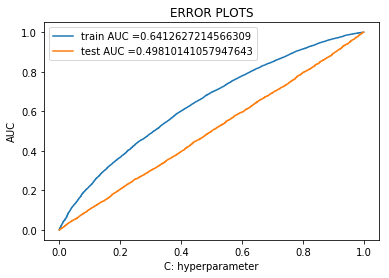

In [188]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve

clf = LogisticRegression()
clf.fit(tfidf_sent_vectors_train, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr_tfw2v, train_tpr_tfw2v, thresholds_tfw2v = roc_curve(Y_train, clf.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr_tfw2v, test_tpr_tfw2v, thresholds_tfw2v = roc_curve(Y_test, clf.predict_proba(tfidf_sent_vectors_test)[:,1])

plt.plot(train_fpr_tfw2v, train_tpr_tfw2v, label="train AUC ="+str(auc(train_fpr_tfw2v, train_tpr_tfw2v)))
plt.plot(test_fpr_tfw2v, test_tpr_tfw2v, label="test AUC ="+str(auc(test_fpr_tfw2v, test_tpr_tfw2v)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

### Calculating Accuracy, Precision, Recall & F1

In [97]:
#L1 Regularizer
clf = LogisticRegression(C = 1000, penalty='l1')

clf.fit(tfidf_sent_vectors_train,Y_train)

predf1 = clf.predict(tfidf_sent_vectors_test)

accw1 = accuracy_score(Y_test, predf1) * 100
prew1 = precision_score(Y_test, predf1) * 100
recw1 = recall_score(Y_test, predf1) * 100
f1w1 = f1_score(Y_test, predf1) * 100


print("Accuracy : " + str(accw1))
print("Precision : " + str(prew1))
print("Recall : "+ str(recw1))
print("F1 : " + str(f1w1))

Accuracy : 84.20552939389336
Precision : 84.33023468454739
Recall : 99.79261530138407
F1 : 91.41217039377231


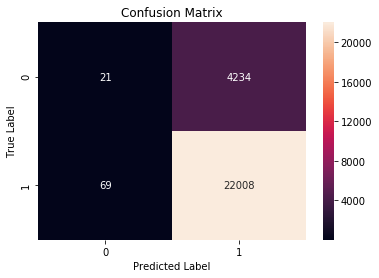

In [190]:
cm = confusion_matrix(Y_test,predf1)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [98]:
#L1 Regularizer
clf = LogisticRegression(C = 1000, penalty='l2')

clf.fit(tfidf_sent_vectors_train,Y_train)

predf2 = clf.predict(tfidf_sent_vectors_test)

accw2 = accuracy_score(Y_test, predf2) * 100
prew2 = precision_score(Y_test, predf2) * 100
recw2 = recall_score(Y_test, predf2) * 100
f1w2 = f1_score(Y_test, predf2) * 100


print("Accuracy : " + str(accw2))
print("Precision : " + str(prew2))
print("Recall : "+ str(recw2))
print("F1 : " + str(f1w2))

Accuracy : 84.22451769709859
Precision : 84.31230728234802
Recall : 99.85122402055813
F1 : 91.42621259029929


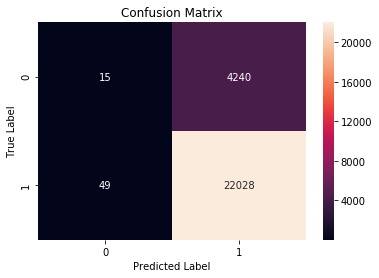

In [192]:
cm = confusion_matrix(Y_test,predf2)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# [6] Conclusions

In [99]:
# Please compare all your models using Prettytable library
number= [1,2,3,4,5,6,7,8]
name= ["Bow", "Bow", "Tfidf", "Tfidf", "Avg W2v", "Avg W2v", "Tfidf W2v", "Tfidf W2v"]
reg= ["L1","L2", "L1", "L2", "L1", "L2", "L1", "L2"]
acc= [accb1,accb2,acct1,acct2,acca1,acca2,accw1,accw2]
pre= [preb1,preb2,pret1,pret2,prea1,pret2,prew1,prew2]
rec= [recb1,recb2,rect1,rect2,reca1,reca2,recw1,recw2]
f1= [f1b1,f1b2,f1t1,f1t2,f1a1,f1a2,f1w1,f1w2]


#Initialize Prettytable
ptable = PrettyTable()
ptable.add_column("Index", number)
ptable.add_column("Model", name)
ptable.add_column("Regularizer", reg)
ptable.add_column("Accuracy%", acc)
ptable.add_column("Precision%", pre)
ptable.add_column("Recall%", rec)
ptable.add_column("F1%", f1)

print(ptable)

+-------+-----------+-------------+-------------------+-------------------+-------------------+-------------------+
| Index |   Model   | Regularizer |     Accuracy%     |     Precision%    |      Recall%      |        F1%        |
+-------+-----------+-------------+-------------------+-------------------+-------------------+-------------------+
|   1   |    Bow    |      L1     |  91.4818471821358 | 93.85062021641593 |  96.1904332536856 | 95.00612267616609 |
|   2   |    Bow    |      L2     | 91.44387057572536 | 93.92910678070717 |  96.0506740002705 | 94.97804426810511 |
|   3   |   Tfidf   |      L1     | 91.77426705149628 | 93.24575428892442 | 97.28145710292593 |  95.2208640395393 |
|   4   |   Tfidf   |      L2     | 91.69831383867538 |  92.3928253402875 | 98.23272169875118 | 95.22331963989161 |
|   5   |  Avg W2v  |      L1     | 84.34984049825309 | 84.92419554455446 | 98.99463504801406 | 91.42119616129234 |
|   6   |  Avg W2v  |      L2     | 84.37262646209935 |  92.392825340287

1. We have taken 100000 data points.
2. Accuracy percentage is more in Bow and Tfidf.
3. Sparsity(non-zero weights) increases as value of C decreases in L1 reguralization.
4. Features are multicollinear.